# Thuật toán ABC



In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
@dataclass
class ABCResult:
    best_position: np.ndarray
    best_value: float               # giá trị f(x) tốt nhất (theo minimize/maximize gốc)
    history_best: List[float]       # best theo từng cycle
    n_evals: int                    # số lần gọi hàm mục tiêu

In [ ]:
def artificial_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    seed: Optional[int] = None,
    return_history: bool = True,
):
    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds, dtype=float)
    lower = bounds_arr[:, 0]
    upper = bounds_arr[:, 1]

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải là số chẵn để chia đôi employed/onlooker.")

    n_sources = colony_size // 2

    def random_food_sources(n: int) -> np.ndarray:
        """Sinh ngẫu nhiên n nghiệm trong miền bounds."""
        return lower + rng.random((n, D)) * (upper - lower)

    def clip_to_bounds(x: np.ndarray) -> np.ndarray:
        """Cắt nghiệm về trong miền."""
        return np.minimum(np.maximum(x, lower), upper)

    # Fitness dựa trên công thức trong bài báo
    def objective_value(x: np.ndarray) -> float:
        val = func(x)
        return val if minimize else -val

    def fitness_from_obj(obj: float) -> float:
        # obj là f(x) theo công thức
        if obj >= 0:
            return 1.0 / (1.0 + obj)
        else:
            return 1.0 + abs(obj)

    # Khởi tạo
    foods = random_food_sources(n_sources)
    obj_vals = np.array([objective_value(x) for x in foods])
    n_evals = n_sources

    fitness = np.array([fitness_from_obj(v) for v in obj_vals])
    trials = np.zeros(n_sources, dtype=int)

    # Best theo objective_value (minimize)
    best_idx = np.argmin(obj_vals)
    best_pos = foods[best_idx].copy()
    best_obj = obj_vals[best_idx]
    history_best = [best_obj] if return_history else []

    # Main loop
    for cycle in range(1, max_cycles + 1):

        # Pha Employed Bees
        for i in range(n_sources):
            # chọn k != i
            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            # chọn chiều j
            j = rng.integers(0, D)

            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            # greedy selection (minimize obj)
            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Pha Onlooker Bees
        fit_sum = np.sum(fitness)
        if fit_sum == 0:
            probs = np.ones(n_sources) / n_sources
        else:
            probs = fitness / fit_sum

        for _ in range(n_sources):  # số onlooker = số sources
            i = rng.choice(n_sources, p=probs)

            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            j = rng.integers(0, D)
            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Pha Scout Bees
        for i in range(n_sources):
            if trials[i] >= limit:
                foods[i] = random_food_sources(1)[0]
                obj_vals[i] = objective_value(foods[i])
                n_evals += 1
                fitness[i] = fitness_from_obj(obj_vals[i])
                trials[i] = 0

        # Cập nhật best
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_obj:
            best_obj = obj_vals[cur_best_idx]
            best_pos = foods[cur_best_idx].copy()

        if return_history:
            history_best.append(best_obj)

    # đổi best_obj về giá trị gốc f(x)
    best_value = best_obj if minimize else -best_obj

    return ABCResult(
        best_position=best_pos,
        best_value=best_value,
        history_best=history_best,
        n_evals=n_evals
    )

# Chạy thử
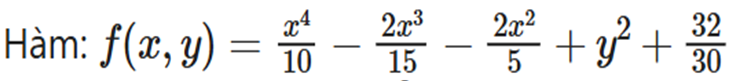!

In [ ]:
# CHẠY THỬ
def test_func(point: np.ndarray) -> float:
    x, y = point[0], point[1]
    return (x**4)/10 - (2*x**3)/15 - (2*x**2)/5 + y**2 + (32/30)


# Miền tìm kiếm của bài toán
bounds = [(-5, 5), (-5, 5)]


# Chạy ABC
result = artificial_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

print("Kết quả xấp xỉ tốt nhất:", result.best_value)
print("Vị trí [x, y] tốt nhất:", result.best_position)
print("Số lần lặp:", result.n_evals)
print("Với miền giá trị [x, y] là: ", bounds)

Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 8.37726978e-09]
Số lần lặp: 20115
Với miền giá trị [x, y] là:  [(-5, 5), (-5, 5)]


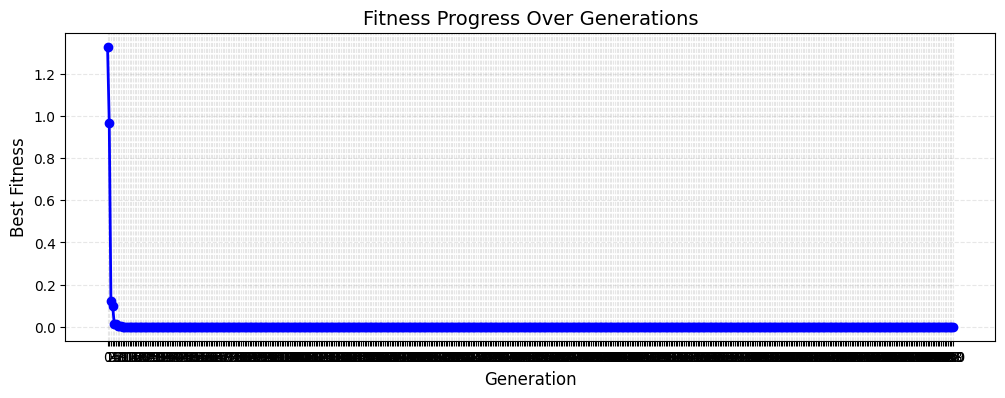

In [ ]:
# FITNESS PLOT


# lấy lịch sử fitness từ ABC
best_history = result.history_best
generations = list(range(len(best_history)))

plt.figure(figsize=(12,4))
plt.plot(generations, best_history, marker='o', color='blue', linestyle='-', linewidth=2)

plt.title("Fitness Progress Over Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Hiển thị
plt.xticks(generations)

plt.show()

# Biến thể của thuật toán ABC

### Thuật toán GABC

In [ ]:
# ===== THUẬT TOÁN GABC (Generalized Artificial Bee Colony) =====
def generalized_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    seed: Optional[int] = None,
    return_history: bool = True,
) -> ABCResult:
    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds, dtype=float)
    lower = bounds_arr[:, 0]
    upper = bounds_arr[:, 1]

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải là số chẵn để chia đôi employed/onlooker.")

    n_sources = colony_size // 2

    def random_food_sources(n: int) -> np.ndarray:
        """Sinh ngẫu nhiên n nghiệm trong miền bounds."""
        return lower + rng.random((n, D)) * (upper - lower)

    def clip_to_bounds(x: np.ndarray) -> np.ndarray:
        """Cắt nghiệm về trong miền."""
        return np.minimum(np.maximum(x, lower), upper)

    def objective_value(x: np.ndarray) -> float:
        """Hàm mục tiêu, đã xử lý minimize/maximize."""
        val = func(x)
        return val if minimize else -val

    def fitness_from_obj(obj: float) -> float:
        """Chuyển objective value -> fitness (theo bài báo ABC)."""
        if obj >= 0:
            return 1.0 / (1.0 + obj)
        else:
            return 1.0 + abs(obj)

    # Khởi tạo
    foods = random_food_sources(n_sources)
    obj_vals = np.array([objective_value(x) for x in foods])
    n_evals = n_sources

    fitness = np.array([fitness_from_obj(v) for v in obj_vals])
    trials = np.zeros(n_sources, dtype=int)

    # Best ban đầu
    best_idx = np.argmin(obj_vals)
    best_pos = foods[best_idx].copy()
    best_obj = obj_vals[best_idx]
    history_best: List[float] = [best_obj] if return_history else []


    for cycle in range(1, max_cycles + 1):

        # ----- Pha Employed Bees-----
        for i in range(n_sources):
            # chọn k != i
            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            # chọn chiều j
            j = rng.integers(0, D)

            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # ----- Pha Onlooker Bees (có term hút về global best) -----
        fit_sum = np.sum(fitness)
        if fit_sum == 0:
            probs = np.ones(n_sources) / n_sources
        else:
            probs = fitness / fit_sum

        for _ in range(n_sources):
            i = rng.choice(n_sources, p=probs)

            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            j = rng.integers(0, D)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = (
                foods[i, j]
                + phi * (foods[i, j] - foods[k, j])
                + psi * (best_pos[j] - foods[i, j])
            )
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # ----- Pha Scout Bees -----
        for i in range(n_sources):
            if trials[i] >= limit:
                foods[i] = random_food_sources(1)[0]
                obj_vals[i] = objective_value(foods[i])
                n_evals += 1
                fitness[i] = fitness_from_obj(obj_vals[i])
                trials[i] = 0

        # ----- Cập nhật best -----
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_obj:
            best_obj = obj_vals[cur_best_idx]
            best_pos = foods[cur_best_idx].copy()

        if return_history:
            history_best.append(best_obj)

    # đổi best_obj về giá trị gốc f(x)
    best_value = best_obj if minimize else -best_obj

    return ABCResult(
        best_position=best_pos,
        best_value=best_value,
        history_best=history_best,
        n_evals=n_evals
    )


### Thuật toán qABC

In [ ]:
# ===== THUẬT TOÁN qABC (quick ABC) =====
def quick_abc(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    r: float = 1.0,               # bán kính neighborhood multiplier
    seed: Optional[int] = None,
):

    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds)
    lower, upper = bounds_arr[:, 0], bounds_arr[:, 1]

    def clip(x):
        return np.minimum(np.maximum(x, lower), upper)

    def obj(x):
        v = func(x)
        return v if minimize else -v

    def fitness(o):
        return 1/(1+o) if o >= 0 else 1 + abs(o)

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải chẵn.")

    n = colony_size // 2

    # Khởi tạo quần thể

    foods = lower + rng.random((n, D)) * (upper - lower)
    obj_vals = np.array([obj(x) for x in foods])
    fits = np.array([fitness(v) for v in obj_vals])
    trials = np.zeros(n, dtype=int)

    best_idx = np.argmin(obj_vals)
    best = foods[best_idx].copy()
    best_val = obj_vals[best_idx]

    # Bắt đầu vòng lặp ABC
    for cycle in range(max_cycles):

        # Employed Bees (giữ nguyên ABC)
        for i in range(n):
            k = rng.integers(0, n)
            while k == i:
                k = rng.integers(0, n)

            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new = foods[i].copy()
            new[j] = foods[i][j] + phi * (foods[i][j] - foods[k][j])
            new = clip(new)

            new_obj = obj(new)
            new_fit = fitness(new_obj)

            if new_obj < obj_vals[i]:
                foods[i] = new
                obj_vals[i] = new_obj
                fits[i] = new_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Onlooker Bees (qABC thay đổi)

        probs = fits / np.sum(fits)

        for _ in range(n):
            # chọn i theo roulette
            i = rng.choice(n, p=probs)

            # --- qABC: xác định neighborhood ---
            # tính khoảng cách trung bình
            dists = np.linalg.norm(foods - foods[i], axis=1)
            md_i = np.mean(np.delete(dists, i))  # bỏ chính nó

            # xác định vùng N_i
            mask = dists <= r * md_i
            Ni = foods[mask]

            # nghiệm tốt nhất vùng
            obj_Ni = np.array([obj(x) for x in Ni])
            idx_best_loc = np.argmin(obj_Ni)
            best_local = Ni[idx_best_loc]

            # ——— sinh nghiệm mới theo công thức qABC ———
            k = rng.integers(0, n)
            while k == i:
                k = rng.integers(0, n)

            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new = best_local.copy()
            new[j] = best_local[j] + phi * (best_local[j] - foods[k][j])
            new = clip(new)

            new_obj = obj(new)
            new_fit = fitness(new_obj)

            if new_obj < obj_vals[i]:
                foods[i] = new
                obj_vals[i] = new_obj
                fits[i] = new_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Scout Bees (giữ nguyên)
        for i in range(n):
            if trials[i] >= limit:
                foods[i] = lower + rng.random(D) * (upper - lower)
                obj_vals[i] = obj(foods[i])
                fits[i] = fitness(obj_vals[i])
                trials[i] = 0

        # Cập nhật best
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_val:
            best_val = obj_vals[cur_best_idx]
            best = foods[cur_best_idx].copy()

    return best, best_val

# So sánh các thuật toán
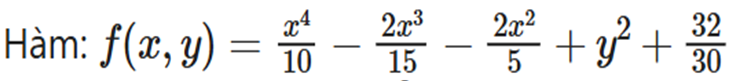

In [ ]:
# CHẠY THỬ – BÀI TOÁN MẪU GIỐNG ẢNH
def test_func(point: np.ndarray) -> float:
    x, y = point[0], point[1]
    return (x**4)/10 - (2*x**3)/15 - (2*x**2)/5 + y**2 + (32/30)

bounds = [(-5, 5), (-5, 5)]

# ABC gốc
result_abc = artificial_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

# GABC
result_gabc = generalized_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

# qABC
result_qabc = quantum_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

def print_result(name: str, result: ABCResult, bounds):
    print(f"===== {name} =====")
    print("Kết quả xấp xỉ tốt nhất:", result.best_value)
    print("Vị trí [x, y] tốt nhất:", result.best_position)
    print("Số lần lặp:", result.n_evals)
    print("Với miền giá trị [x, y] là:", bounds)
    print("------------------------------------------\n")

print_result("ABC gốc", result_abc, bounds)
print_result("GABC", result_gabc, bounds)
print_result("qABC", result_qabc, bounds)



===== ABC gốc =====
Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 8.37726978e-09]
Số lần lặp: 20115
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------

===== GABC =====
Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 5.08619424e-09]
Số lần lặp: 20120
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------

===== qABC =====
Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 3.81637399e-09]
Số lần lặp: 20122
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------



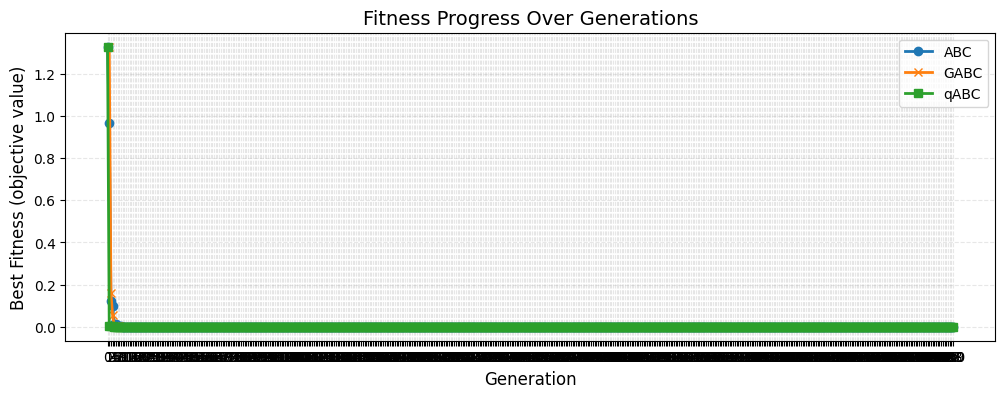

In [ ]:
# FITNESS PLOT – SO SÁNH ABC, GABC, qABC

plt.figure(figsize=(12, 4))

gen_abc  = list(range(len(result_abc.history_best)))
gen_gabc = list(range(len(result_gabc.history_best)))
gen_qabc = list(range(len(result_qabc.history_best)))

plt.plot(gen_abc,  result_abc.history_best,  marker='o', linewidth=2, label="ABC")
plt.plot(gen_gabc, result_gabc.history_best, marker='x', linewidth=2, label="GABC")
plt.plot(gen_qabc, result_qabc.history_best, marker='s', linewidth=2, label="qABC")

plt.title("Fitness Progress Over Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Fitness (objective value)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.xticks(gen_abc)

plt.show()
